In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms
from gala.units import galactic

import pickle

In [7]:
plt.style.use('notebook')

In [8]:
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [9]:
ham = gp.Hamiltonian(gp.MilkyWayPotential())

In [110]:
c = pickle.load(open('../data/fits/orbit_gd1.pkl', 'rb'))

In [111]:
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
orbit = ham.integrate_orbit(w0, dt=-0.1*u.Myr, n_steps=600)
model = orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

In [112]:
ind_prog = np.argmin(np.abs(model.phi1 + 20.5*u.deg))
# ind_prog = np.argmin(np.abs(model.phi1 + 40.75*u.deg))

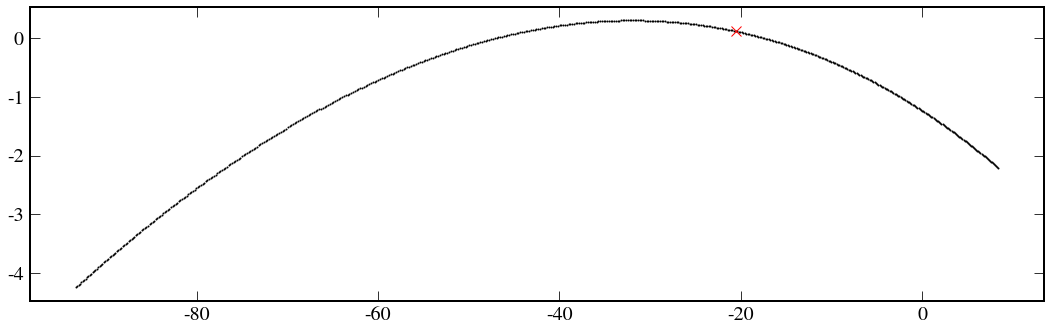

In [113]:
plt.figure(figsize=(15,5))
plt.plot(model.phi1, model.phi2, 'ko', ms=1)
plt.plot(model.phi1[ind_prog], model.phi2[ind_prog], 'rx', ms=10)

# plt.gca().set_aspect('equal')
plt.tight_layout()

In [114]:
df = ms.FardalStreamDF()

In [115]:
# orbit back
gd1_cen = model[ind_prog]
rep = gd1_cen.transform_to(gc_frame).data
gd1_w0 = gd.PhaseSpacePosition(rep)
dt = 1*u.Myr
n_steps = 3000

orbit_rr = ham.integrate_orbit(gd1_w0, dt=-dt, n_steps=n_steps)

w0_init = gd.PhaseSpacePosition(orbit_rr.data[-1])
t = np.abs(orbit_rr.t)

In [116]:
np.random.seed(294)

n_disrupt = 1000
n_particles = np.ones(n_steps+1, dtype=int)
n_particles[-n_disrupt:] = 0

minit = 7e3
mfin = 1e1
nrelease = 1
t_disrupt = -dt*n_disrupt
n_times = (orbit_rr.t <= t_disrupt).sum()
prog_mass = np.linspace(minit, mfin, n_times)
prog_mass = np.concatenate((prog_mass, np.zeros(len(orbit_rr.t) - n_times)*1e-5)) * u.Msun

gen_gd1 = ms.MockStreamGenerator(df, ham)
gd1_np, _ = gen_gd1.run(w0_init, prog_mass, dt=dt, t=t, n_particles=n_particles)
gd1_np_eq = gd1_np.to_coord_frame(coord.ICRS)
gd1c_np = gd1_np.to_coord_frame(gc.GD1)

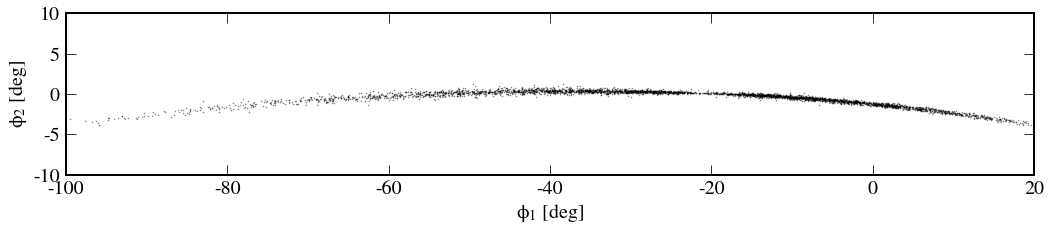

In [117]:
plt.figure(figsize=(15,5))
plt.plot(gd1c_np.phi1[:], gd1c_np.phi2[:], 'k.', ms=1, alpha=0.5)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.xlim(-100, 20)
plt.ylim(-10,10)
plt.gca().set_aspect('equal')
plt.tight_layout()

In [118]:
gc_params = {}
gc_params['NGC 4590'] = dict(mass=1.2e5*u.Msun, rh=7.58*u.pc)
gc_params['NGC 6584'] = dict(mass=1e5*u.Msun, rh=5.37*u.pc)
gc_params['NGC 6864'] = dict(mass=3.7e5*u.Msun, rh=2.96*u.pc)

In [201]:
name = 'NGC 6864'
# name = 'NGC 4590'
# name = 'NGC 6584'

In [202]:
tgc = Table.read('../data/gc_best.fits')
ind = [True if name==name_ else False for name_ in tgc['Name']]
tgc = tgc[ind]

In [203]:
c_gc = coord.SkyCoord(ra=tgc['RAdeg'], dec=tgc['DEdeg'], 
                      distance=tgc['plx_adpt'].to(u.kpc, equivalencies=u.parallax()), 
                      pm_ra_cosdec=tgc['pmRA'], pm_dec=tgc['pmDE'], radial_velocity=tgc['HRV'], frame='icrs')
w0_gc = gd.PhaseSpacePosition(c_gc.transform_to(gc_frame).cartesian)

In [204]:
pkl = pickle.load(open('../data/gc_impact/impact_{:s}.pkl'.format(name), 'rb'))

In [216]:
ind = pkl['dmin']<0.2
# ind = np.argmin(pkl['dmin'])
print(pkl['dmin'][ind])

[0.06679241 0.17018498 0.19922402 0.19623063 0.17329299 0.12474341
 0.15492344 0.09370354 0.16893916 0.14831692 0.19842179 0.19921569
 0.16229713 0.10589153 0.10624883 0.07951286]


In [217]:
w0_gc = pkl['w0'][ind][-1]
orbit_gc_rr = ham.integrate_orbit(w0_gc, dt=-dt, n_steps=n_steps)
w0_gc_init = gd.PhaseSpacePosition(orbit_gc_rr.data[-1])

In [218]:
fplum = (0.5**(-2/3)-1)**0.5
gc_pot = [gp.PlummerPotential(gc_params[name]['mass']*10, fplum*gc_params[name]['rh'], units=galactic)]
gc_nbody = gd.DirectNBody(w0_gc_init, gc_pot, external_potential=ham.potential,
                          units=galactic, save_all=True)

In [219]:
np.random.seed(294)

# n_disrupt = 1000
# n_particles = np.ones(n_steps+1, dtype=int)
# n_particles[-n_disrupt:] = 0

# minit = 7e3
# mfin = 1e1
# nrelease = 1
# t_disrupt = -dt*n_disrupt
# n_times = (orbit_rr.t <= t_disrupt).sum()
# prog_mass = np.linspace(minit, mfin, n_times)
# prog_mass = np.concatenate((prog_mass, np.zeros(len(orbit_rr.t) - n_times)*1e-5)) * u.Msun

# gen_gd1 = ms.MockStreamGenerator(df, ham)
gd1_gc, _ = gen_gd1.run(w0_init, prog_mass, dt=dt, t=t, n_particles=n_particles, nbody=gc_nbody)
gd1_gc_eq = gd1_gc.to_coord_frame(coord.ICRS)
gd1c_gc = gd1_gc.to_coord_frame(gc.GD1)

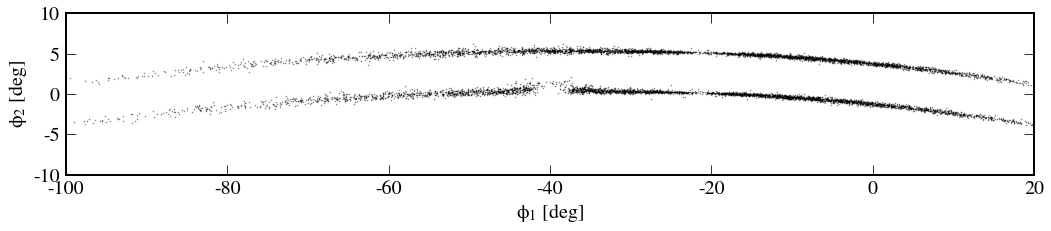

In [220]:
plt.figure(figsize=(15,5))
plt.plot(gd1c_np.phi1[:], gd1c_np.phi2[:]+5*u.deg, 'k.', ms=1, alpha=0.5)
plt.plot(gd1c_gc.phi1[:], gd1c_gc.phi2[:], 'k.', ms=1, alpha=0.5)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.xlim(-100, 20)
plt.ylim(-10,10)
plt.gca().set_aspect('equal')
plt.tight_layout()